In [105]:
import pandas as pd
import numpy as np
import scipy
import re
import string

import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
from wordcloud import WordCloud


from sklearn.model_selection import train_test_split as split
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer 
from nltk.stem import PorterStemmer, LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from textblob import TextBlob
import warnings
warnings.filterwarnings('ignore') 

from IPython.display import Image

%matplotlib inline

In [106]:
import os

os.chdir("/temp")

df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)
print(df.shape)
df.head(3)


(23486, 10)


,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses


In [107]:
df.groupby(['Rating', 'Recommended IND'])['Recommended IND'].count()

Rating  Recommended IND
1       0                    826
        1                     16
2       0                   1471
        1                     94
3       0                   1682
        1                   1189
4       0                    168
        1                   4909
5       0                     25
        1                  13106
Name: Recommended IND, dtype: int64

In [108]:
df.loc[(df.Rating==5) & (df['Recommended IND']==0)]['Review Text'].iloc[1]

"This top is one of my retailer faves! it is so comfortable and love the quality and design. i receive many compliments on this top. i usually wear an xs or s in retailer tops and the xs was a little tight in the arms. the dressing room attendant suggested ordering a petite small so i wouldn't lose the shape. so glad i did. it fits perfect! i even ordered when it was on sale!! the gray color is perfect! its not too thick or thin."

In [109]:
text_df = df[['Title', 'Review Text', 'Recommended IND']]
text_df.head()

,Title,Review Text,Recommended IND
0,NaN,Absolutely wonderful - silky and sexy and comf...,1
1,NaN,Love this dress! it's sooo pretty. i happene...,1
2,Some major design flaws,I had such high hopes for this dress and reall...,0
3,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",1
4,Flattering shirt,This shirt is very flattering to all due to th...,1


In [110]:
text_df['Review'] = text_df['Title'] + ' ' + text_df['Review Text']
text_df = text_df.drop(labels=['Title','Review Text'] , axis=1)
text_df.head()

,Recommended IND,Review
0,1,NaN
1,1,NaN
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...


In [111]:
text_df.Review.isna().sum()

3811

In [112]:
text_df = text_df[~text_df.Review.isna()]
text_df = text_df.rename(columns={"Recommended IND": "Recommended"})
print("My data's shape is:", text_df.shape)
text_df.head()

My data's shape is: (19675, 2)


,Recommended,Review
2,0,Some major design flaws I had such high hopes ...
3,1,"My favorite buy! I love, love, love this jumps..."
4,1,Flattering shirt This shirt is very flattering...
5,0,Not for the very petite I love tracy reese dre...
6,1,Cagrcoal shimmer fun I aded this in my basket ...


In [113]:
text_df['Recommended'].unique()

array([0, 1], dtype=int64)

In [114]:
text_df['Recommended'].value_counts(normalize=True)

1    0.818297
0    0.181703
Name: Recommended, dtype: float64

In [115]:
text_df['Review_length'] = text_df['Review'].apply(len)
print(text_df.shape)
text_df.head()

(19675, 3)


,Recommended,Review,Review_length
2,0,Some major design flaws I had such high hopes ...,524
3,1,"My favorite buy! I love, love, love this jumps...",141
4,1,Flattering shirt This shirt is very flattering...,209
5,0,Not for the very petite I love tracy reese dre...,512
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517


In [116]:
text_df['Review_length'].describe()

count    19675.000000
mean       338.450267
std        144.740126
min         23.000000
25%        217.000000
50%        336.000000
75%        496.000000
max        557.000000
Name: Review_length, dtype: float64

<AxesSubplot:xlabel='Review_length', ylabel='Density'>

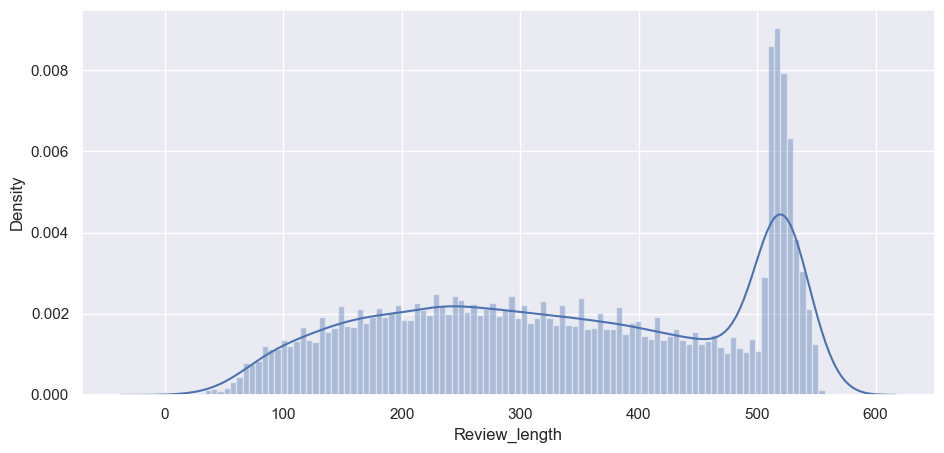

In [117]:
sns.set(rc={'figure.figsize':(11,5)})
sns.distplot(text_df['Review_length'] ,hist=True, bins=100)

In [118]:
df_zero = text_df[text_df['Recommended']==0]
df_one = text_df[text_df['Recommended']==1]

<AxesSubplot:ylabel='Density'>

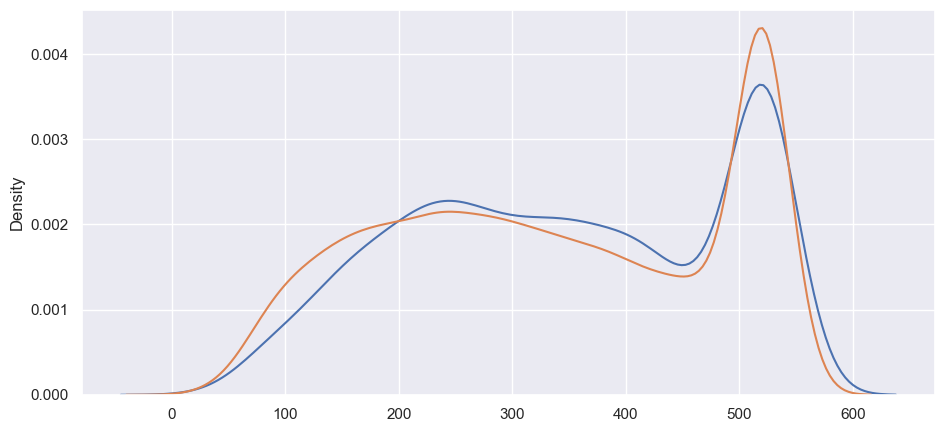

In [119]:
sns.distplot(df_zero[['Review_length']] ,hist=False)
sns.distplot(df_one[['Review_length']], hist=False)

In [120]:
def count_exclamation_mark(string_text):
    count = 0
    for char in string_text:
        if char == '!':
            count += 1
    return count

In [121]:
text_df['count_exc'] = text_df['Review'].apply(count_exclamation_mark)
text_df.head(5)

,Recommended,Review,Review_length,count_exc
2,0,Some major design flaws I had such high hopes ...,524,1
3,1,"My favorite buy! I love, love, love this jumps...",141,3
4,1,Flattering shirt This shirt is very flattering...,209,3
5,0,Not for the very petite I love tracy reese dre...,512,0
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0


In [122]:
text_df['count_exc'].describe(np.arange(0.2, 1.0, 0.2))

count    19675.000000
mean         0.883151
std          1.412098
min          0.000000
20%          0.000000
40%          0.000000
50%          0.000000
60%          1.000000
80%          2.000000
max         41.000000
Name: count_exc, dtype: float64

<AxesSubplot:>

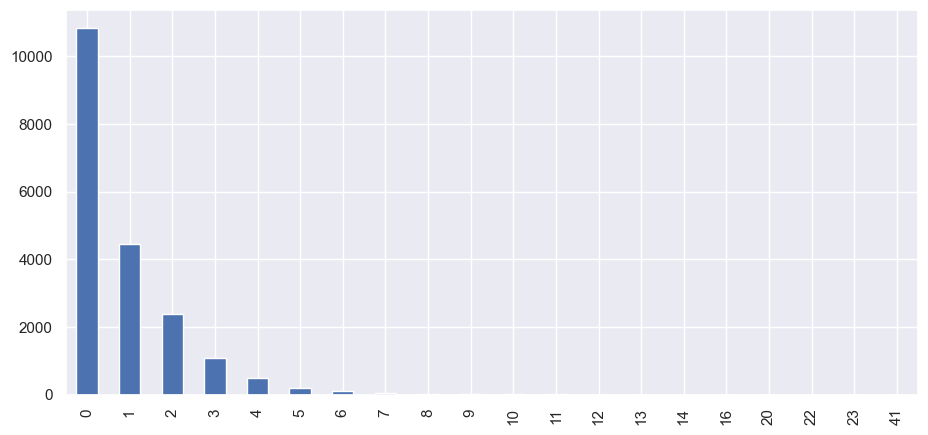

In [123]:
text_df['count_exc'].value_counts().sort_index().plot(kind='bar')

In [124]:
text_df[text_df['count_exc']== 41].index

Int64Index([3301], dtype='int64')

In [125]:
text_df['Review'][3301]

'Beautiful and unique. Love this top, just received it today.\r\nit is a very artistic interpretation for a casual top.\r\nthe blue is gorgeous!\r\nthe unique style of the peplm and the details on the front set this apart!\r\nruns a little shorter, but i feel the length enhances it;s beauty, and is appropriate for the overall design.\r\nlove !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!\r\nordered my usual size and it fits perfectly.'

In [126]:
text_df['Polarity'] = text_df['Review'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df.head(5)

,Recommended,Review,Review_length,count_exc,Polarity
2,0,Some major design flaws I had such high hopes ...,524,1,0.073209
3,1,"My favorite buy! I love, love, love this jumps...",141,3,0.560714
4,1,Flattering shirt This shirt is very flattering...,209,3,0.512891
5,0,Not for the very petite I love tracy reese dre...,512,0,0.181111
6,1,Cagrcoal shimmer fun I aded this in my basket ...,517,0,0.157500


<AxesSubplot:ylabel='Frequency'>

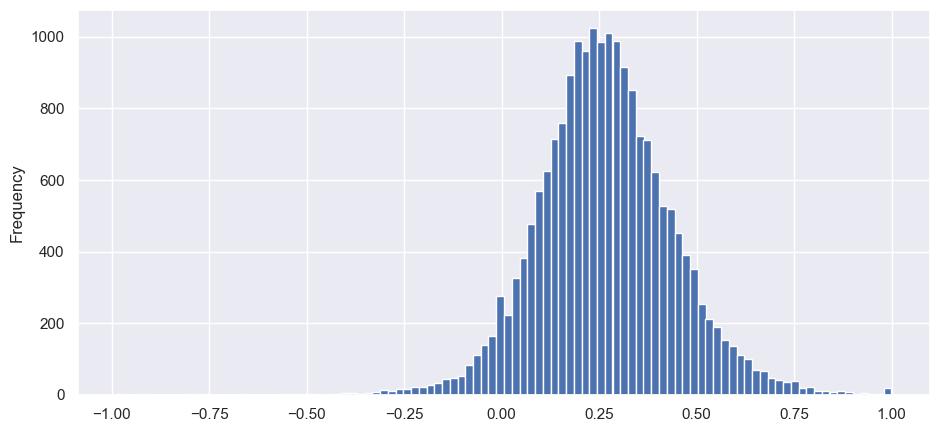

In [127]:
text_df['Polarity'].plot(kind='hist', bins=100)

In [128]:
text_prep = text_df.copy()

In [129]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [130]:
def punctuation_removal(messy_str):
    clean_list = [char for char in messy_str if char not in string.punctuation]
    clean_str = ''.join(clean_list)
    return clean_str

In [131]:
text_prep['Review'] = text_prep['Review'].apply(punctuation_removal)
text_prep['Review'].head()

2    Some major design flaws I had such high hopes ...
3    My favorite buy I love love love this jumpsuit...
4    Flattering shirt This shirt is very flattering...
5    Not for the very petite I love tracy reese dre...
6    Cagrcoal shimmer fun I aded this in my basket ...
Name: Review, dtype: object

In [134]:
def adj_collector(review_string):
    new_string=[]
    review_string = word_tokenize(review_string)
    tup_word = nltk.pos_tag(review_string)
    for tup in tup_word:
        if 'VB' in tup[1] or tup[1]=='JJ':  #Verbs and Adjectives
            new_string.append(tup[0])  
    return ' '.join(new_string)

In [135]:
# text_prep['Review'] = text_prep['Review'].apply(adj_collector)
# text_prep['Review'].head(7)

LookupError: 
**********************************************************************
  Resource [93maveraged_perceptron_tagger[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('averaged_perceptron_tagger')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtaggers/averaged_perceptron_tagger/averaged_perceptron_tagger.pickle[0m

  Searched in:
    - 'C:\\Users\\yujin/nltk_data'
    - 'c:\\ProgramData\\Anaconda3\\envs\\yujinyeo\\nltk_data'
    - 'c:\\ProgramData\\Anaconda3\\envs\\yujinyeo\\share\\nltk_data'
    - 'c:\\ProgramData\\Anaconda3\\envs\\yujinyeo\\lib\\nltk_data'
    - 'C:\\Users\\yujin\\AppData\\Roaming\\nltk_data'
    - 'C:\\nltk_data'
    - 'D:\\nltk_data'
    - 'E:\\nltk_data'
**********************************************************************


In [86]:
print(stopwords.words('english')[::12])

['i', "you'd", 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', "don't", 'aren', 'haven', "shan't"]


In [87]:
stop = stopwords.words('english')
stop.append("i'm")

In [88]:
stop_words = []

for item in stop: 
    new_item = punctuation_removal(item)
    stop_words.append(new_item) 
print(stop_words[::12])

['i', 'youd', 'hers', 'which', 'were', 'a', 'at', 'above', 'again', 'both', 'own', 'dont', 'aren', 'haven', 'shant']


In [89]:
clothes_list =['dress', 'top','sweater','shirt',
               'skirt','material', 'white', 'black',
              'jeans', 'fabric', 'color','order', 'wear']

In [90]:
def stopwords_removal(messy_str):
    messy_str = word_tokenize(messy_str)
    return [word.lower() for word in messy_str 
            if word.lower() not in stop_words and word.lower() not in clothes_list ]

In [91]:
text_prep['Review'] = text_prep['Review'].apply(stopwords_removal)
text_prep['Review'].head()

2    [major, design, flaws, high, hopes, really, wa...
3    [favorite, buy, love, love, love, jumpsuit, fu...
4    [flattering, flattering, due, adjustable, fron...
5    [petite, love, tracy, reese, dresses, one, pet...
6    [cagrcoal, shimmer, fun, aded, basket, hte, la...
Name: Review, dtype: object

In [92]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)

In [93]:
text_prep['Review'] = text_prep['Review'].apply(drop_numbers)
text_prep['Review'].head()

2    major design flaws high hopes really wanted wo...
3    favorite buy love love love jumpsuit fun flirt...
4    flattering flattering due adjustable front tie...
5    petite love tracy reese dresses one petite fee...
6    cagrcoal shimmer fun aded basket hte last mint...
Name: Review, dtype: object

In [94]:
print(text_prep['Review'][267]) 

nice quality short tall frame love look quality jacket say fits true size way short tall wish came tall sizes


In [95]:
print(text_prep['Review'][2293])

flattering purchased reviewsunfortunately return expected fit said lbs got petite could even get chest waist chest really disappointed soft would purchase regular fit would looked terrible would say tall thin girl yes short girl petite


In [96]:
porter = PorterStemmer()

In [97]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [major, design, flaws, high, hopes, really, wa...
3    [favorite, buy, love, love, love, jumpsuit, fu...
4    [flattering, flattering, due, adjustable, fron...
5    [petite, love, tracy, reese, dresses, one, pet...
6    [cagrcoal, shimmer, fun, aded, basket, hte, la...
Name: Review, dtype: object

In [98]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [99]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [major, design, flaw, high, hope, realli, want...
3    [favorit, buy, love, love, love, jumpsuit, fun...
4    [flatter, flatter, due, adjust, front, tie, pe...
5    [petit, love, traci, rees, dress, one, petit, ...
6    [cagrcoal, shimmer, fun, ade, basket, hte, las...
Name: Review, dtype: object

In [100]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    major design flaw high hope realli want work i...
3    favorit buy love love love jumpsuit fun flirti...
4    flatter flatter due adjust front tie perfect l...
5    petit love traci rees dress one petit feet tal...
6    cagrcoal shimmer fun ade basket hte last mintu...
Name: Review, dtype: object

In [101]:
print(text_prep['Review'][2293])

flatter purchas reviewsunfortun return expect fit said lb got petit could even get chest waist chest realli disappoint soft would purchas regular fit would look terribl would say tall thin girl ye short girl petit


In [136]:
porter = PorterStemmer()

In [137]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: x.split())
text_prep['Review'].head()

2    [Some, major, design, flaws, I, had, such, hig...
3    [My, favorite, buy, I, love, love, love, this,...
4    [Flattering, shirt, This, shirt, is, very, fla...
5    [Not, for, the, very, petite, I, love, tracy, ...
6    [Cagrcoal, shimmer, fun, I, aded, this, in, my...
Name: Review, dtype: object

In [138]:
def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = porter.stem(word)
        text_list_new.append(word) 
    return text_list_new

In [139]:
text_prep['Review'] = text_prep['Review'].apply(stem_update)
text_prep['Review'].head()

2    [some, major, design, flaw, i, had, such, high...
3    [my, favorit, buy, i, love, love, love, thi, j...
4    [flatter, shirt, thi, shirt, is, veri, flatter...
5    [not, for, the, veri, petit, i, love, traci, r...
6    [cagrcoal, shimmer, fun, i, ade, thi, in, my, ...
Name: Review, dtype: object

In [140]:
text_prep['Review'] = text_prep['Review'].apply(lambda x: ' '.join(x))
text_prep['Review'].head()

2    some major design flaw i had such high hope fo...
3    my favorit buy i love love love thi jumpsuit i...
4    flatter shirt thi shirt is veri flatter to all...
5    not for the veri petit i love traci rees dress...
6    cagrcoal shimmer fun i ade thi in my basket at...
Name: Review, dtype: object

In [141]:
print(text_prep['Review'][2293])

can be flatter i purchas thi dress off the reviewsunfortun i have to return it i expect it to fit as they said i am 51 120 lb 35bc i got the s petit i could not even get thi dress on over my chest the waist wa on top of my chest i realli wa disappoint the materi is so soft i would have had to purchas a m in a regular to fit me and it would have look terribl on me so i would say for a tall thin girl ye a short girl a no and i am veri petit


In [142]:
pos_df = text_prep[text_prep.Recommended== 1]
neg_df = text_prep[text_prep.Recommended== 0]
pos_df.head(3)

,Recommended,Review,Review_length,count_exc,Polarity
3,1,my favorit buy i love love love thi jumpsuit i...,141,3,0.560714
4,1,flatter shirt thi shirt is veri flatter to all...,209,3,0.512891
6,1,cagrcoal shimmer fun i ade thi in my basket at...,517,0,0.157500


In [143]:
pos_words =[]
neg_words = []

for review in pos_df.Review:
    pos_words.append(review) 
pos_words = ' '.join(pos_words)
pos_words[:40]

for review in neg_df.Review:
    neg_words.append(review)
neg_words = ' '.join(neg_words)
neg_words[:400]

'some major design flaw i had such high hope for thi dress and realli want it to work for me i initi order the petit small my usual size but i found thi to be outrag small so small in fact that i could not zip it up i reorder it in petit medium which wa just ok overal the top half wa comfort and fit nice but the bottom half had a veri tight under layer and sever somewhat cheap net over layer imo a '

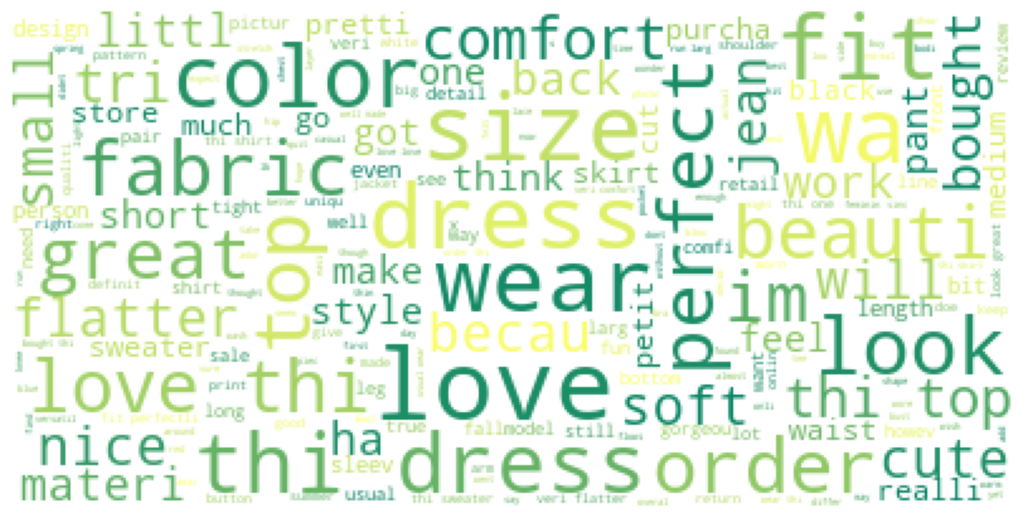

In [144]:
wordcloud = WordCloud().generate(pos_words)

wordcloud = WordCloud(background_color="white",max_words=len(pos_words),\
                      max_font_size=40, relative_scaling=.5, colormap='summer').generate(pos_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

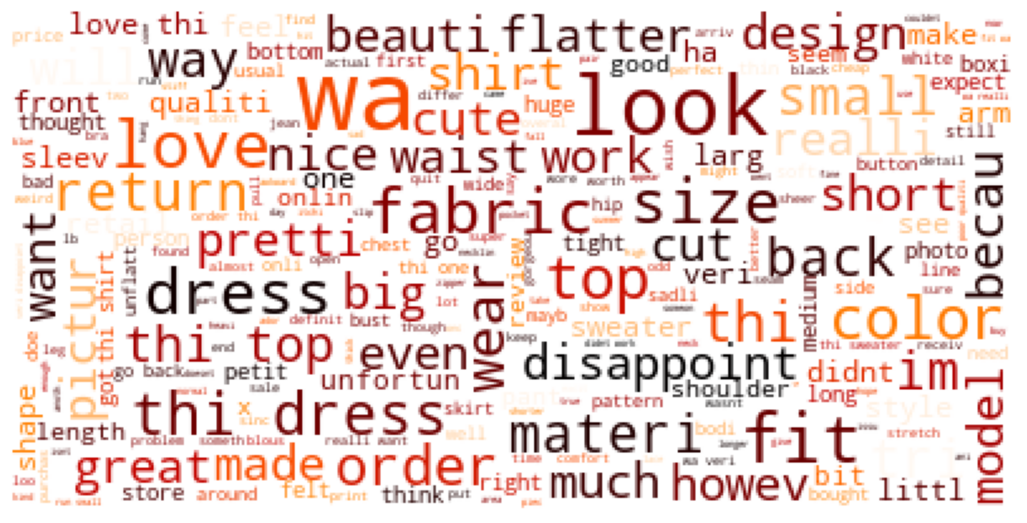

In [145]:
wordcloud = WordCloud().generate(neg_words)

wordcloud = WordCloud(background_color="white",max_words=len(neg_words),\
                      max_font_size=40, relative_scaling=.5, colormap='gist_heat').generate(neg_words)
plt.figure(figsize=(13,13))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [146]:
text_prep['Review'].head()

2    some major design flaw i had such high hope fo...
3    my favorit buy i love love love thi jumpsuit i...
4    flatter shirt thi shirt is veri flatter to all...
5    not for the veri petit i love traci rees dress...
6    cagrcoal shimmer fun i ade thi in my basket at...
Name: Review, dtype: object

In [147]:
def text_vectorizing_process(sentence_string):
    return [word for word in sentence_string.split()]

In [148]:
bow_transformer = CountVectorizer(text_vectorizing_process)

In [149]:
bow_transformer.fit(text_prep['Review'])

CountVectorizer(input=<function text_vectorizing_process at 0x00000195AEF3BDC0>)

In [150]:
print(text_prep['Review'].iloc[3])

not for the veri petit i love traci rees dress but thi one is not for the veri petit i am just under 5 feet tall and usual wear a 0p in thi brand thi dress wa veri pretti out of the packag but it a lot of dress the skirt is long and veri full so it overwhelm my small frame not a stranger to alter shorten and narrow the skirt would take away from the embellish of the garment i love the color and the idea of the style but it just did not work on me i return thi dress


In [151]:
Reviews = bow_transformer.transform(text_prep['Review'])
Reviews

<19675x14773 sparse matrix of type '<class 'numpy.int64'>'
	with 887496 stored elements in Compressed Sparse Row format>

In [153]:
[i for i in bow_transformer.vocabulary_.items() if i[1]==3507]

[('coveral', 3507)]

In [154]:
[i for i in bow_transformer.vocabulary_.items()][6:60:10]

[('high', 6185),
 ('work', 14501),
 ('but', 2525),
 ('zip', 14752),
 ('half', 5993),
 ('somewhat', 11913)]

In [155]:
messages_tfidf = tfidf_transformer.transform(Reviews)
messages_tfidf.shape

(19675, 14773)

In [ ]:
print(messages_tfidf[:1]) 